#**Project II - Explainable COVID-19 Pneumonia**





# **1.Preparing the data**

**Mount Google Drive content to access datasets from MILA, Figure 1 and RSNA**


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/My\ Drive/NJIT/CS677/CS677_Project_II/covid-cxr

/content/gdrive/My Drive/NJIT/CS677/CS677_Project_II/covid-cxr


**Install packages**

In [ ]:
!pip install -r requirements.txt
!pip install pydicom
!sudo pip install "pyyaml==5.1" #version 5.1

**Import packages and set up paths**

In [ ]:
import numpy as np
import pandas as pd
import pydicom as dicom
import yaml
import os
import pathlib
import shutil
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))  # Load config data

# Get paths of raw datasets to be included
mila_data_path = cfg['PATHS']['MILA_DATA']
fig1_data_path = cfg['PATHS']['FIGURE1_DATA']
rsna_data_path = cfg['PATHS']['RSNA_DATA']


Mila data path: /content/gdrive/My Drive/NJIT/CS677/CS677_Project_II/covid-cxr/data/covid-chestxray-dataset/
Figure1 data path: /content/gdrive/My Drive/NJIT/CS677/CS677_Project_II/covid-cxr/data/Figure1-COVID-chestxray-dataset/
RSNA data path: /content/gdrive/My Drive/NJIT/CS677/CS677_Project_II/covid-cxr/data/rsna/


**Prepare MILA data**

Read metadata.csv file in MILA data
Then update the filename column with actual path


In [ ]:
# Assemble filenames comprising Mila dataset
mila_df = pd.read_csv(mila_data_path + 'metadata.csv') #Read metadata.csv file in MILA data
mila_df['filename'] = mila_data_path + 'images/' + mila_df['filename'].astype(str) #update the filename column with actual path
mila_df.head(5)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,/content/gdrive/My Drive/NJIT/CS677/CS677_Proj...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,/content/gdrive/My Drive/NJIT/CS677/CS677_Proj...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,/content/gdrive/My Drive/NJIT/CS677/CS677_Proj...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,/content/gdrive/My Drive/NJIT/CS677/CS677_Proj...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,/content/gdrive/My Drive/NJIT/CS677/CS677_Proj...,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


Combine the two conditions (Desired X-ray views and COVID19 cases):

In [ ]:
mila_views_cxrs_df = (mila_df['view'].str.contains('|'.join(cfg['DATA']['VIEWS'])))    # Select desired X-ray views
mila_covid_pts_df = (mila_df['finding'] == 'COVID-19') # select Covid cases
mila_covid_views_df = mila_df[mila_covid_pts_df & mila_views_cxrs_df]  # Images for patients diagnosed with COVID-19

**Prepare for the other datasets - Figure 1 and RSNA**


In [ ]:
# Assemble filenames comprising Figure 1 dataset
fig1_df = pd.read_csv(fig1_data_path + 'metadata.csv', encoding='ISO-8859-1')
fig1_df['filename'] = ''
for i, row in fig1_df.iterrows():
    if os.path.exists(fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.jpg'):
        fig1_df.loc[i, 'filename'] = fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.jpg'
    else:
        fig1_df.loc[i, 'filename'] = fig1_data_path + 'images/' + fig1_df.loc[i, 'patientid'] + '.png'
fig1_df['view'].fillna('PA or AP', inplace=True)    # All images in this dataset are either AP or PA
fig1_views_cxrs_df = (fig1_df['view'].str.contains('|'.join(cfg['DATA']['VIEWS'])))    # Select desired X-ray views
fig1_covid_pts_df = (fig1_df['finding'] == 'COVID-19')
fig1_covid_views_df = fig1_df[fig1_covid_pts_df & fig1_views_cxrs_df]  # Images for patients diagnosed COVID-19

# Assemble filenames comprising RSNA dataset
rsna_metadata_path = rsna_data_path + 'stage_2_train_labels.csv'
rsna_df = pd.read_csv(rsna_metadata_path)
num_rsna_imgs = cfg['DATA']['NUM_RSNA_IMGS']
rsna_normal_df = rsna_df[rsna_df['Target'] == 0]
rsna_pneum_df = rsna_df[rsna_df['Target'] == 1]

# Convert dicom files of CXRs with no findings to jpg if not done already in a previous run. Select desired views.
file_counter = 0
normal_idxs = []
for df_idx in rsna_normal_df.index.values.tolist():
    filename = rsna_normal_df.loc[df_idx]['patientId']
    ds = dicom.dcmread(os.path.join(rsna_data_path + 'stage_2_train_images/' + filename + '.dcm'))
    if any(view in ds.SeriesDescription.split(' ')[1] for view in cfg['DATA']['VIEWS']):  # Select desired X-ray views
        if not os.path.exists(rsna_data_path + filename + '.jpg'):
            cv2.imwrite(os.path.join(rsna_data_path + filename + '.jpg'), ds.pixel_array)   # Save as .jpg
        normal_idxs.append(df_idx)
        file_counter += 1
    if file_counter >= num_rsna_imgs // 2:
        break
rsna_normal_df = rsna_normal_df.loc[normal_idxs]


# Convert dicom files of CXRs with pneumonia to jpg if not done already in a previous run. Select desired views.
file_counter = 0
pneum_idxs = []
num_remaining = num_rsna_imgs - num_rsna_imgs // 2
for df_idx in rsna_pneum_df.index.values.tolist():
    filename = rsna_pneum_df.loc[df_idx]['patientId']
    ds = dicom.dcmread(os.path.join(rsna_data_path + 'stage_2_train_images/' + filename + '.dcm'))
    if any(view in ds.SeriesDescription.split(' ')[1] for view in cfg['DATA']['VIEWS']):  # Select desired X-ray views
        if not os.path.exists(rsna_data_path + filename + '.jpg'):
            cv2.imwrite(os.path.join(rsna_data_path + filename + '.jpg'), ds.pixel_array)  # Save as .jpg
        pneum_idxs.append(df_idx)
        file_counter += 1
    if file_counter >= num_remaining:
        break
rsna_pneum_df = rsna_pneum_df.loc[pneum_idxs]

In [ ]:
print('The shape of RSNA No condition dataframe:', rsna_normal_df.shape)
print('The shape of RSNA Pneumonia dataframe:', rsna_pneum_df.shape)
rsna_normal_df.head(3)


The shape of RSNA No condition dataframe: (500, 6)
The shape of RSNA Pneumonia dataframe: (500, 6)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0


**Only apply the binary model, since we are only concerned if it is covid or not**

In [ ]:
mode = cfg['TRAIN']['CLASS_MODE'] #'non-COVID-19', 'COVID-19'
n_classes = len(cfg['DATA']['CLASSES']) #2
class_dict = {cfg['DATA']['CLASSES'][i]: i for i in range(n_classes)}  # Map class name to number
label_dict = {i: cfg['DATA']['CLASSES'][i] for i in range(n_classes)}  # Map class name to number

print('Mode:', mode)
print('Number of classes:',n_classes)
print('Class dictionary:',class_dict)
print('Label dictionary:',label_dict)

Mode: binary
Number of classes: 2
Class dictionary: {'non-COVID-19': 0, 'COVID-19': 1}
Label dictionary: {0: 'non-COVID-19', 1: 'COVID-19'}


**Modify all datasets for binary model and concatenate them together**

In [ ]:
mila_covid_views_df['label'] = 1                                       # Mila images with COVID-19 diagnosis
mila_other_views_df = mila_df[~mila_covid_pts_df & mila_views_cxrs_df]
mila_other_views_df['label'] = 0                                       # Mila images with alternative diagnoses
fig1_covid_views_df['label'] = 1                                       # Figure 1 images with COVID-19 diagnosis
file_df = pd.concat([mila_covid_views_df[['filename', 'label']], mila_other_views_df[['filename', 'label']],
                      fig1_covid_views_df[['filename', 'label']]], axis=0)

rsna_df = pd.concat([rsna_normal_df, rsna_pneum_df], axis=0)
rsna_filenames = rsna_data_path + rsna_df['patientId'].astype(str) + '.jpg'
rsna_file_df = pd.DataFrame({'filename': rsna_filenames, 'label': 0})

file_df = pd.concat([file_df, rsna_file_df], axis=0)         # Combine both datasets
file_df['label_str'] = file_df['label'].map(label_dict) # Add column for string representation of label


**Do the splits for model training**

In [ ]:
# Split dataset into train, val and test sets
val_split = cfg['DATA']['VAL_SPLIT']
test_split = cfg['DATA']['TEST_SPLIT']
file_df_train, file_df_test = train_test_split(file_df, test_size=test_split, stratify=file_df['label'])
relative_val_split = val_split / (1 - test_split)  # Calculate fraction of train_df to be used for validation
file_df_train, file_df_val = train_test_split(file_df_train, test_size=relative_val_split, stratify=file_df_train['label'])

print('Validation Percentage:', val_split)
print('Test Percentage:', test_split)
print('Relative Validation Percentage:', relative_val_split)

print('Shape of Training data:',file_df_train.shape )
print('Shape of Validation data:',file_df_val.shape )
print('Shape of Testing data:',file_df_test.shape )

# Save training, validation and test sets
file_df_train.to_csv(cfg['PATHS']['TRAIN_SET'])
file_df_val.to_csv(cfg['PATHS']['VAL_SET'])
file_df_test.to_csv(cfg['PATHS']['TEST_SET'])

Validation Percentage: 0.08
Test Percentage: 0.1
Relative Validation Percentage: 0.08888888888888889
Shape of Training data: (1489, 3)
Shape of Validation data: (146, 3)
Shape of Testing data: (182, 3)


**Remove the texts on X-ray** 

In [ ]:
# define a fuction to remove texts

def remove_text(img):
    '''
    Attempts to remove bright textual artifacts from X-ray images. For example, many images indicate the right side of
    the body with a white 'R'. Works only for very bright text.
    :param img: Numpy array of image
    :return: Array of image with (ideally) any characters removed and inpainted
    '''
    mask = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)[1][:, :, 0].astype(np.uint8)
    img = img.astype(np.uint8)
    result = cv2.inpaint(img, mask, 10, cv2.INPAINT_NS).astype(np.float32)
    return result

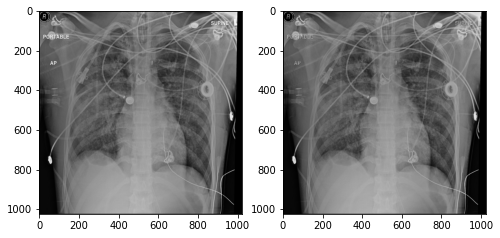

In [ ]:
# test for texts removal

import glob
import matplotlib.pyplot as plt

cv_img = []
path= glob.glob(data['TRAIN'].values[987][0])
path=path[0]
img = cv2.imread(path)
img_rmv=remove_text(img)

fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
fig.add_subplot(rows, columns, 2)
plt.imshow(img_rmv.astype(np.uint8))



# **2. Training**

In [ ]:
# import libraries

import datetime
import random
import dill
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.summary as tf_summary
from imblearn.over_sampling import RandomOverSampler
from math import ceil
from tensorflow.keras.metrics import BinaryAccuracy, CategoricalAccuracy, Precision, Recall, AUC
from tensorflow.keras.models import save_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorboard.plugins.hparams import api as hp

In [ ]:
# Set logs directory
save_weights=True
write_logs=True
cur_date = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = cfg['PATHS']['LOGS'] + "training" + cur_date if write_logs else None
if not os.path.exists(cfg['PATHS']['LOGS'] + "training"):
    os.makedirs(cfg['PATHS']['LOGS'] + "training")


In [ ]:
# Load dataset file paths and labels
data = {} 
data['TRAIN'] = file_df_train
data['VAL'] = file_df_val
data['TEST'] = file_df_test

In [ ]:
# Set callbacks.
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=cfg['TRAIN']['PATIENCE'], mode='min', restore_best_weights=True)
callbacks = [early_stopping]

# Append tensorboard to callback list
if write_logs:
  tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
  callbacks.append(tensorboard)

In [ ]:
# Create ImageDataGenerators
train_img_gen = ImageDataGenerator(rotation_range=10, preprocessing_function=remove_text,
                                    samplewise_std_normalization=True, samplewise_center=True)
val_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                    samplewise_std_normalization=True, samplewise_center=True)
test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                    samplewise_std_normalization=True, samplewise_center=True)


In [ ]:
# Create DataFrameIterators
img_shape = tuple(cfg['DATA']['IMG_DIM'])
y_col = 'label_str'
class_mode = 'categorical'
train_generator = train_img_gen.flow_from_dataframe(dataframe=data['TRAIN'], directory=None,
    x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'], class_mode=class_mode)
val_generator = val_img_gen.flow_from_dataframe(dataframe=data['VAL'], directory=None,
    x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'], class_mode=class_mode)
test_generator = test_img_gen.flow_from_dataframe(dataframe=data['TEST'], directory=None,
    x_col="filename", y_col=y_col, target_size=img_shape, batch_size=cfg['TRAIN']['BATCH_SIZE'], class_mode=class_mode,
    shuffle=False)

Found 1489 validated image filenames belonging to 2 classes.
Found 146 validated image filenames belonging to 2 classes.
Found 182 validated image filenames belonging to 2 classes.


In [ ]:
# Save model's ordering of class indices
dill.dump(test_generator.class_indices, open(cfg['PATHS']['OUTPUT_CLASS_INDICES'], 'wb'))
print(test_generator.class_indices)

{'COVID-19': 0, 'non-COVID-19': 1}


In [ ]:
# Apply class imbalance strategy. We have many more X-rays negative for COVID-19 than positive.

# Get class mutliplier [the tweaking part]
class_multiplier = cfg['TRAIN']['CLASS_MULTIPLIER']
class_multiplier = [class_multiplier[cfg['DATA']['CLASSES'].index(c)] for c in test_generator.class_indices]
print('Class Multiplier:', class_multiplier)

#get the actual class weights
class_weight = None
histogram = np.bincount(np.array(train_generator.labels).astype(int))  # Get class distribution
print('COVID-19 cases vs Non COVID-19 in the training set:', histogram)


weights = [None] * len(histogram)
for i in range(len(histogram)):
    weights[i] = (1.0 / len(histogram)) * sum(histogram) / histogram[i]
class_weight_d = {i: weights[i] for i in range(len(histogram))}
print('Class weights before class multiplier: ', weights)
class_weight = [class_weight_d[i] * class_multiplier[i] for i in range(len(histogram))]
print('Class weights after class multiplier: ', class_weight)

Class Multiplier: [1.0, 0.15]
COVID-19 cases vs Non COVID-19 in the training set: [  28 1461]
Class weights before class multiplier:  [26.589285714285715, 0.5095824777549623]
Class weights after class multiplier:  [26.589285714285715, 0.07643737166324435]


In [ ]:
# Define metrics.
covid_class_idx = test_generator.class_indices['COVID-19']   # Get index of COVID-19 class
thresholds = 1.0 / len(cfg['DATA']['CLASSES'])      # Binary classification threshold for a class
metrics = [CategoricalAccuracy(name='accuracy'),
            Precision(name='precision', thresholds=thresholds, class_id=covid_class_idx),
            Recall(name='recall', thresholds=thresholds, class_id=covid_class_idx),
            AUC(name='auc'),
            F1Score(name='f1score', thresholds=thresholds, class_id=covid_class_idx)]

**Use resnet50v2 for model training**

In [ ]:
# Define the model.
print('Training distribution: ', ['Class ' + list(test_generator.class_indices.keys())[i] + ': ' + str(histogram[i]) + '. '
        for i in range(len(histogram))])  #printing histogram values for each class
input_shape = cfg['DATA']['IMG_DIM'] + [3] #adding the third dimention for channel (RGB)
print('Input Shape:', input_shape)
num_gpus = cfg['TRAIN']['NUM_GPUS']
print('Number of GPUs: ', num_gpus)
model_def = resnet50v2

histogram = np.bincount(data['TRAIN']['label'].astype(int))
print('Histogram info: ', histogram)
output_bias = np.log([histogram[i] / (np.sum(histogram) - histogram[i]) for i in range(histogram.shape[0])])
print('Output Bias: ', output_bias)
model = model_def(cfg['NN']['DCNN_BINARY'], input_shape, metrics, 2, output_bias=output_bias, gpus=1)


Training distribution:  ['Class COVID-19: 28. ', 'Class non-COVID-19: 1461. ']
Input Shape: [224, 224, 3]
Number of GPUs:  2
Histogram info:  [1461   28]
Output Bias:  [ 3.9546719 -3.9546719]
MODEL CONFIG:  {'KERNEL_SIZE': '(3,3)', 'STRIDES': '(1,1)', 'INIT_FILTERS': 16, 'FILTER_EXP_BASE': 3, 'MAXPOOL_SIZE': '(2,2)', 'CONV_BLOCKS': 3, 'NODES_DENSE0': 128, 'LR': 0.0003, 'OPTIMIZER': 'adam', 'DROPOUT': 0.4, 'L2_LAMBDA': 0.0001}
94674944/94668760 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                

In [ ]:
# Train the model.
steps_per_epoch = ceil(train_generator.n / train_generator.batch_size)
print('Steps Per Epoch: ',steps_per_epoch)
val_steps = ceil(val_generator.n / val_generator.batch_size)
print('Validation Steps: ',val_steps)
epochs=epochs=cfg['TRAIN']['EPOCHS']
print('Epochs: ', epochs)
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs,
                              validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks,
                              verbose=1, class_weight=class_weight_d)

Steps Per Epoch:  47
Validation Steps:  5
Epochs:  200
Train for 47 steps, validate for 5 steps
Epoch 1/200
47/47 [==============================] - 151s 3s/step - loss: 0.6032 - accuracy: 0.8818 - precision: 0.0256 - recall: 0.1429 - auc: 0.9189 - f1score: 0.0435 - val_loss: 1.6683 - val_accuracy: 0.9795 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9795 - val_f1score: 0.0000e+00
Epoch 2/200
47/47 [==============================] - 102s 2s/step - loss: 0.1018 - accuracy: 0.9778 - precision: 0.3333 - recall: 0.1786 - auc: 0.9949 - f1score: 0.2326 - val_loss: 0.8613 - val_accuracy: 0.9795 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9795 - val_f1score: 0.0000e+00
Epoch 3/200
47/47 [==============================] - 101s 2s/step - loss: 0.0491 - accuracy: 0.9919 - precision: 0.8333 - recall: 0.7143 - auc: 0.9996 - f1score: 0.7692 - val_loss: 0.5569 - val_accuracy: 0.9795 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9795 - val_

Save the trained MODEL in a .h5 format:

In [ ]:
if save_weights:
  model_path = cfg['PATHS']['MODEL_WEIGHTS'] + 'model' + '.h5'
  save_model(model, model_path)  # Save the model's weights

In [ ]:
np.save('my_history.npy',history.history)

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# **3. Evaluation**

Run the trained model on the testing data set. Summary of the performance metrics:

In [ ]:
# Run the model on the test set and print the resulting performance metrics.
test_results = model.evaluate(test_generator, verbose=1, steps=len(test_generator))
test_metrics = {}
test_summary_str = [['**Metric**', '**Value**']]
for metric, value in zip(model.metrics_names, test_results):
    test_metrics[metric] = value
    print(metric, ' = ', value)
    test_summary_str.append([metric, str(value)])
return model, test_metrics, test_generator


6/6 [==============================] - 38s 6s/step - loss: 0.1545 - accuracy: 0.9725 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.9917 - f1score: 0.0000e+00
loss  =  0.15453721582889557
accuracy  =  0.97252744
precision  =  0.0
recall  =  0.0
auc  =  0.99169785
f1score  =  0.0


We plot the receiver operating characteristic curve, or ROC curve, to illustrates the diagnostic ability of a binary classifier

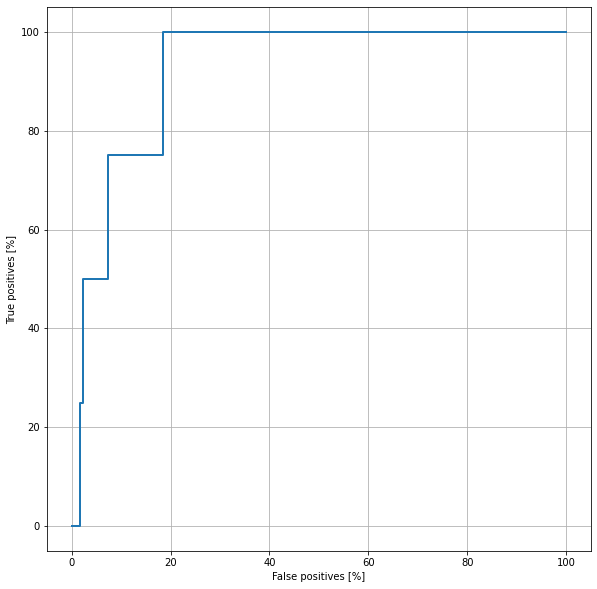

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import io
import os
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries

# Set some matplotlib parameters
mpl.rcParams['figure.figsize'] = (12, 10)

def plot_to_tensor():
    '''
    Converts a matplotlib figure to an image tensor
    :param figure: A matplotlib figure
    :return: Tensorflow tensor representing the matplotlib image
    '''
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)

    image_tensor = tf.image.decode_png(buf.getvalue(), channels=4)     # Convert .png buffer to tensorflow image
    image_tensor = tf.expand_dims(image_tensor, 0)     # Add the batch dimension
    return image_tensor

def plot_roc(name, labels, predictions, class_id=1, dir_path=None):
    '''
    Plots the ROC curve for predictions on a dataset
    :param name: Name of dataset on the plot
    :param labels: Ground truth labels
    :param predictions: Model predictions corresponding to the labels
    :param class_id: Index of class to consider
    :param dir_path: Directory in which to save image
    '''
    plt.clf()
    single_class_preds = predictions[:, class_id]    # Only care about one class
    single_class_labels = (np.array(labels) == class_id) * 1.0
    predictions = single_class_preds
    labels = single_class_labels
    fp, tp, _ = roc_curve(labels, predictions)  # Get values for true positive and true negative
    plt.plot(100*fp, 100*tp, label=name, linewidth=2)   # Plot the ROC curve
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-5,105])
    plt.ylim([-5,105])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        plt.savefig(dir_path + 'ROC_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png')
    return plt


# Visualization of test results
test_predictions = model.predict_generator(test_generator, verbose=0, steps=len(test_generator))
test_labels = test_generator.labels
covid_idx = test_generator.class_indices['COVID-19']
plt = plot_roc("Test set", test_labels, test_predictions, class_id=covid_idx)
roc_img = plot_to_tensor()


True (-)ves:  177 
False (+)ves:  1 
False (-)ves:  4 
True (+)ves:  0


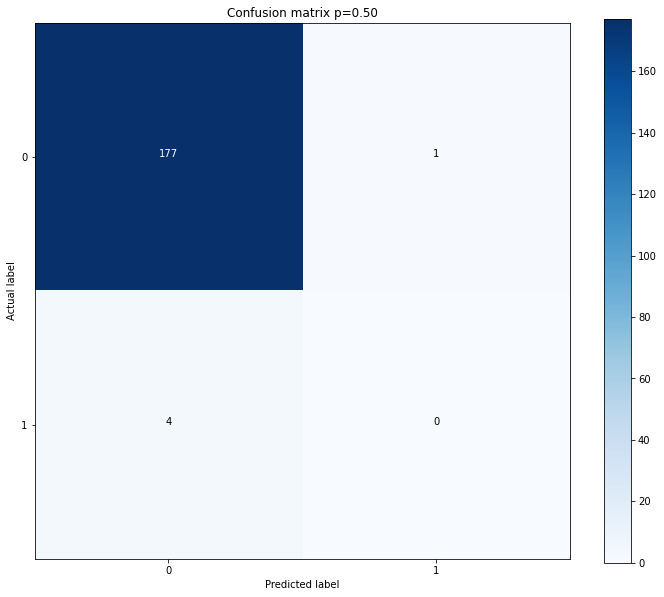

In [ ]:
def plot_confusion_matrix(labels, predictions, class_id=1, dir_path=None):
    '''
    Plot a confusion matrix for the ground truth labels and corresponding model predictions for a particular class.
    :param labels: Ground truth labels
    :param predictions: Model predictions
    :param class_id: Index of class to consider
    :param dir_path: Directory in which to save image
    '''
    plt.clf()
    p = 1.0 / np.unique(labels).shape[0]
    single_class_preds = predictions[:, class_id]    # Only care about one class
    single_class_labels = (np.array(labels) == class_id) * 1.0
    predictions = single_class_preds
    labels = single_class_labels
    ax = plt.subplot()
    cm = confusion_matrix(labels, predictions > p)  # Calculate confusion matrix
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Plot confusion matrix
    ax.figure.colorbar(im, ax=ax)
    ax.set(yticks=[-0.5, 1.5], xticks=[0, 1], yticklabels=['0', '1'], xticklabels=['0', '1'])
    ax.yaxis.set_major_locator(mpl.ticker.IndexLocator(base=1, offset=0.5))

    # Print number of TPs, FPs, TNs, FNs on each quadrant in the plot
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Set plot's title and axis names
    plt.title('Confusion matrix p={:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    # Save the image
    if dir_path is not None:
        plt.savefig(dir_path + 'CM_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png')

    # Print these statistics
    print('True (-)ves: ', cm[0][0], '\nFalse (+)ves: ', cm[0][1], '\nFalse (-)ves: ', cm[1][0], '\nTrue (+)ves: ',
          cm[1][1])
    return plt
plt = plot_confusion_matrix(test_labels, test_predictions, class_id=covid_idx)
cm_img = plot_to_tensor()

# **4. Explainability**

## **Lime Explainer:**

In [ ]:
!pip install lime

In [ ]:
from lime.lime_image import *
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from datetime import datetime
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from lime.wrappers.scikit_image import SegmentationAlgorithm
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries

def visualize_explanation(orig_img, explanation, img_filename, label, probs, class_names, label_to_see='top', dir_path=None):
    '''
    Visualize an explanation for the prediction of a single X-ray image.
    :param orig_img: Original X-Ray image
    :param explanation: ImageExplanation object
    :param img_filename: Filename of the image explained
    :param label: Ground truth class of the example
    :param probs: Prediction probabilities
    :param class_names: Ordered list of class names
    :param label_to_see: Label to visualize in explanation
    :param dir_path: Path to directory where to save the generated image
    :return: Path to saved image
    '''

    # Plot original image on the left
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(orig_img)

    # Plot the image and its explanation on the right
    if label_to_see == 'top':
        label_to_see = explanation.top_labels[0]
    explanation.image = orig_img
    temp, mask = explanation.get_image_and_mask(label_to_see, positive_only=False, num_features=10,
                                                hide_rest=False)
    ax[1].imshow(mark_boundaries(temp, mask))

    # Display some information about the example
    pred_class = np.argmax(probs)
    fig.text(0.02, 0.8, "Prediction probabilities: " + str(['{:.2f}'.format(probs[i]) for i in range(len(probs))]),
             fontsize=10)
    fig.text(0.02, 0.82, "Predicted Class: " + str(pred_class) + ' (' + class_names[pred_class] + ')', fontsize=10)
    if label is not None:
        fig.text(0.02, 0.84, "Ground Truth Class: " + str(label) + ' (' + class_names[label] + ')', fontsize=10)
    fig.suptitle("LIME Explanation for image " + img_filename, fontsize=15)
    fig.tight_layout()

    # Save the image
    filename = None
    if dir_path is not None:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        filename = dir_path + img_filename + '_exp_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '.png'
        plt.savefig(filename)
    return filename



Found 182 validated image filenames belonging to 2 classes.
182/182 [==============================] - 16s 87ms/step


Intercept 0.0580911394086648
Prediction_local [0.04689651]
Right: 0.0014602621
Intercept 0.9419088469704501
Prediction_local [0.9531035]
Right: 0.9985398


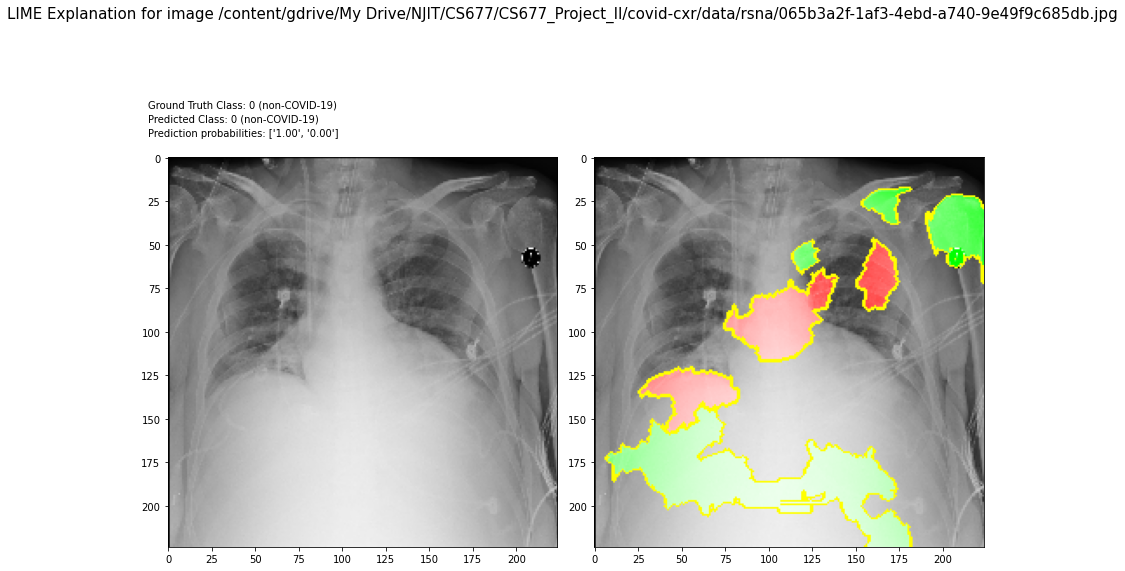

In [ ]:
from lime.lime_image import *
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from datetime import datetime
from lime.wrappers.scikit_image import SegmentationAlgorithm
from sklearn.metrics import confusion_matrix, roc_curve
from skimage.segmentation import mark_boundaries
def predict_and_explain(x, model, exp, num_features, num_samples):
    '''
    Use the model to predict a single example and apply LIME to generate an explanation.
    :param x: Preprocessed image to predict
    :param model: The trained neural network model
    :param exp: A LimeImageExplainer object
    :param num_features: # of features to use in explanation
    :param num_samples: # of times to perturb the example to be explained
    :return: The LIME explainer for the instance
    '''

    def predict(x):
        '''
        Helper function for LIME explainer. Runs model prediction on perturbations of the example.
        :param x: List of perturbed examples from an example
        :return: A numpy array constituting a list of class probabilities for each predicted perturbation
        '''
        probs = predict_instance(x, model)
        return probs

    # Algorithm for superpixel segmentation. Parameters set to limit size of superpixels and promote border smoothness
    segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=2.25, max_dist=50, ratio=0.1, sigma=0.15)

    # Generate explanation for the example
    explanation = exp.explain_instance(x, predict, num_features=num_features, num_samples=num_samples, segmentation_fn=segmentation_fn)
    probs = predict_instance(np.expand_dims(x, axis=0), model)
    return explanation, probs


def predict_instance(x, model):
    '''
    Runs model prediction on 1 or more input images.
    :param x: Image(s) to predict
    :param model: A Keras model
    :return: A numpy array comprising a list of class probabilities for each prediction
    '''
    y = model.predict(x)  # Run prediction on the perturbations
    if y.shape[1] == 1:
        probs = np.concatenate([1.0 - y, y], axis=1)  # Compute class probabilities from the output of the model
    else:
        probs = y
    return probs

def setup_lime():
    '''
    Load relevant information and create a LIME Explainer
    :return: dict containing important information and objects for explanation experiments
    '''

    # Load relevant constants from project config file
    cfg = yaml.full_load(open(os.getcwd() + "/config.yml", 'r'))
    lime_dict = {}
    lime_dict['NUM_SAMPLES'] = cfg['LIME']['NUM_SAMPLES']
    lime_dict['NUM_FEATURES'] = cfg['LIME']['NUM_FEATURES']
    lime_dict['IMG_PATH'] = cfg['PATHS']['IMAGES']
    lime_dict['IMG_DIM'] = cfg['DATA']['IMG_DIM']
    lime_dict['PRED_THRESHOLD'] = cfg['PREDICTION']['THRESHOLD']
    lime_dict['CLASSES'] = cfg['DATA']['CLASSES']
    lime_dict['CLASS_MODE'] = cfg['TRAIN']['CLASS_MODE']
    lime_dict['COVID_ONLY'] = cfg['LIME']['COVID_ONLY']
    KERNEL_WIDTH = cfg['LIME']['KERNEL_WIDTH']
    FEATURE_SELECTION = cfg['LIME']['FEATURE_SELECTION']

    # Load train and test sets
    lime_dict['TRAIN_SET'] = pd.read_csv(cfg['PATHS']['TRAIN_SET'])
    lime_dict['TEST_SET'] = pd.read_csv(cfg['PATHS']['TEST_SET'])

    # Create ImageDataGenerator for test set
    test_img_gen = ImageDataGenerator(preprocessing_function=remove_text,
                                       samplewise_std_normalization=True, samplewise_center=True)
    test_generator = test_img_gen.flow_from_dataframe(dataframe=lime_dict['TEST_SET'], directory=None,
        x_col="filename", y_col='label_str', target_size=tuple(cfg['DATA']['IMG_DIM']), batch_size=1,
        class_mode='categorical', shuffle=False)
    lime_dict['TEST_GENERATOR'] = test_generator

    # Define the LIME explainer
    lime_dict['EXPLAINER'] = LimeImageExplainer(kernel_width=KERNEL_WIDTH, feature_selection=FEATURE_SELECTION,
                                                verbose=True)
    dill.dump(lime_dict['EXPLAINER'], open(cfg['PATHS']['LIME_EXPLAINER'], 'wb'))    # Serialize the explainer

    # Load trained model's weights
    #lime_dict['MODEL'] = load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)
    lime_dict['MODEL']=model
    test_predictions = lime_dict['MODEL'].predict_generator(test_generator, verbose=1,steps=len(test_generator))
    return lime_dict


def explain_xray(lime_dict, idx, save_exp=True):
    '''
    Make a prediction and provide a LIME explanation
    :param lime_dict: dict containing important information and objects for explanation experiments
    :param idx: index of image in test set to explain
    :param save_exp: Boolean indicating whether to save the explanation visualization
    '''

    # Get i'th preprocessed image in test set
    lime_dict['TEST_GENERATOR'].reset()
    for i in range(idx + 1):
        x, y = lime_dict['TEST_GENERATOR'].next()
    x = np.squeeze(x, axis=0)

    # Get the corresponding original image (no preprocessing)
    orig_img = cv2.imread( lime_dict['TEST_SET']['filename'][idx])
    new_dim = tuple(lime_dict['IMG_DIM'])
    orig_img = cv2.resize(orig_img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image

    # Make a prediction for this image and retrieve a LIME explanation for the prediction
    explanation, probs = predict_and_explain(x, lime_dict['MODEL'], lime_dict['EXPLAINER'],
                                      lime_dict['NUM_FEATURES'], lime_dict['NUM_SAMPLES'])


    # Get image filename and label
    img_filename = lime_dict['TEST_SET']['filename'][idx]
    label = lime_dict['TEST_SET']['label'][idx]

    # Rearrange prediction probability vector to reflect original ordering of classes in project config
    probs = [probs[0][lime_dict['CLASSES'].index(c)] for c in lime_dict['TEST_GENERATOR'].class_indices]

    # Visualize the LIME explanation and optionally save it to disk
    if save_exp:
        file_path = lime_dict['IMG_PATH']
    else:
        file_path = None
    if lime_dict['COVID_ONLY'] == True:
        label_to_see = lime_dict['TEST_GENERATOR'].class_indices['COVID-19']
    else:
        label_to_see = 'top'
    _ = visualize_explanation(orig_img, explanation, img_filename, label, probs, lime_dict['CLASSES'], label_to_see=label_to_see
                          )
    return


lime_dict = setup_lime()
i = 3                                                    # Select i'th image in test set
explain_xray(lime_dict, i, save_exp=True)                   # Generate explanation for image

## **Shapely Explainer:**

In [ ]:
!pip install shap

In [ ]:
pip install tensorflow==2.2.0

In [ ]:
import tensorflow as tf 
tf.__version__

'2.0.1'

In [ ]:
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap
import glob
import matplotlib.pyplot as plt


samples=len(data['TRAIN'])
X=np.full((samples,224,224,3), 0)
y=np.full((samples), 0)
new_dim=tuple(lime_dict['IMG_DIM'])
for i in range(samples):
  cv_img = []
  path= glob.glob(data['TRAIN'].values[i][0])
  path=path[0]
  img = cv2.imread(path)
  orig_img = cv2.resize(img, new_dim, interpolation=cv2.INTER_NEAREST)     # Resize image
  X[i]=orig_img
  y[i]= data['TRAIN'].values[i][1]# Get the corresponding original image (no preprocessing)

to_explain = X[[1]]
model=load_model(cfg['PATHS']['MODEL_TO_LOAD'], compile=False)
# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)


e = shap.GradientExplainer(model, X, session=None, local_smoothing=0)
# get the names for the classes
#index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)


In [ ]:
shap_values,indexes = e.shap_values(map2layer(to_explain, 2), ranked_outputs=2)


**Shap doesn't work with TF2, but Resnet model was built on TF2. As a result, we couldn't process it.**